In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Import the dataset that we will work with
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv('iris.csv', names= cols)
# Drop the first row as it contains coloumn names
df = df.iloc[1:]

In [5]:
print(df.head(), '\n')
print(df.info())

  sepal_length sepal_width petal_length petal_width        class
1          5.1         3.5          1.4         0.2  Iris-setosa
2          4.9           3          1.4         0.2  Iris-setosa
3          4.7         3.2          1.3         0.2  Iris-setosa
4          4.6         3.1          1.5         0.2  Iris-setosa
5            5         3.6          1.4         0.2  Iris-setosa 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sepal_length  150 non-null    object
 1   sepal_width   150 non-null    object
 2   petal_length  150 non-null    object
 3   petal_width   150 non-null    object
 4   class         150 non-null    object
dtypes: object(5)
memory usage: 6.0+ KB
None


In [6]:
# Check for missing Values
print(df.isnull().sum())

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
class           0
dtype: int64


In [7]:
# Convert the 'class' column to categorical
df['class'] = df['class'].astype('category')

num_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Convert the numerical columns to numeric types, handling potential errors
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display updated data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   sepal_length  150 non-null    float64 
 1   sepal_width   150 non-null    float64 
 2   petal_length  150 non-null    float64 
 3   petal_width   150 non-null    float64 
 4   class         150 non-null    category
dtypes: category(1), float64(4)
memory usage: 5.1 KB
None


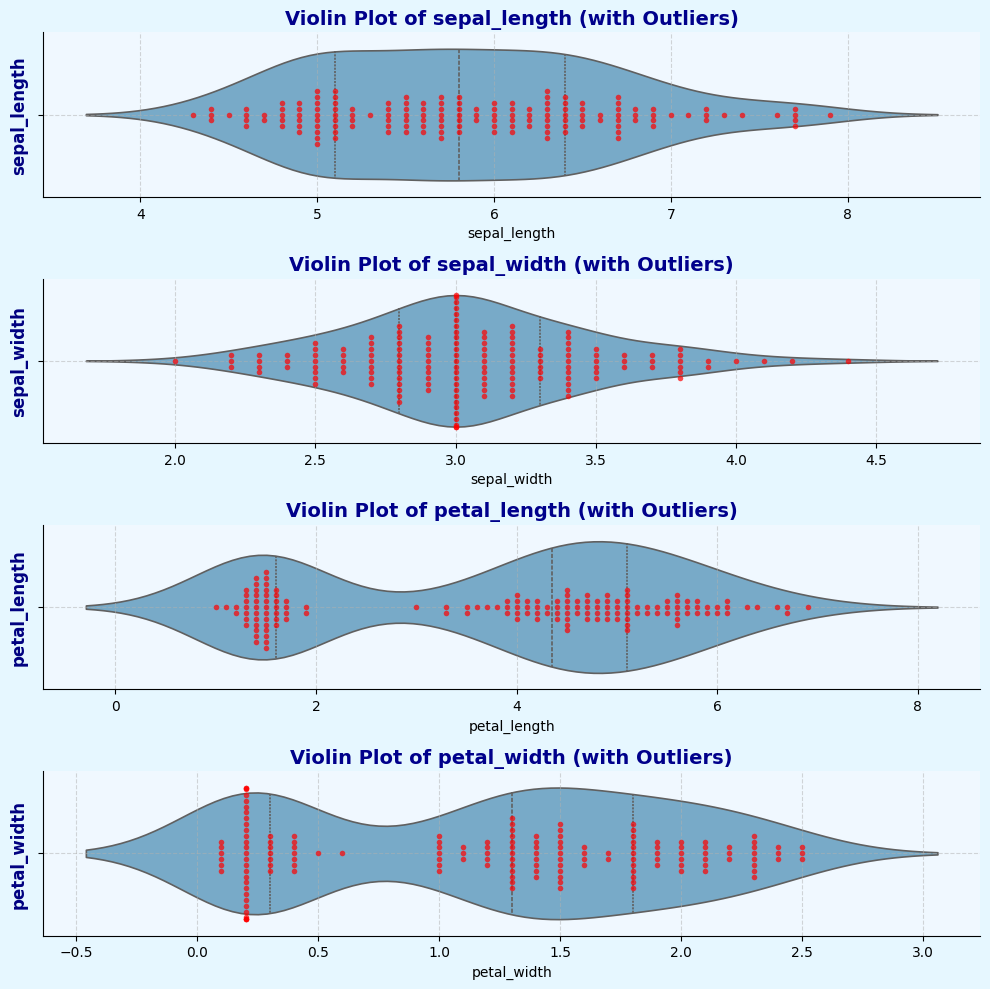

In [8]:
# Viloin plot for outliers detection

# Set figure size dynamically
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10, len(num_cols) * 2.5), sharex=False)

# Set overall background color
fig.patch.set_facecolor('#E6F7FF')  # Light blue background

# Ensure axes is always iterable
if len(num_cols) == 1:
    axes = [axes]

# Loop through each feature and create a violin plot with swarmplot
for i, feature in enumerate(num_cols):
    sns.violinplot(x=df[feature], ax=axes[i], inner="quartile", palette="Blues", linewidth=1.2)

    # Overlay swarmplot to highlight individual points, especially outliers
    sns.swarmplot(x=df[feature], ax=axes[i], color="red", alpha=0.7, size=4)

    axes[i].set_ylabel(feature, fontsize=12, fontweight='bold', color='navy')
    axes[i].grid(True, linestyle="--", alpha=0.5)
    axes[i].set_facecolor("#F0F8FF")  # Light pastel background for subplots
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    # Add title
    axes[i].set_title(f'Violin Plot of {feature} (with Outliers)', fontsize=14, fontweight="bold", color="darkblue")

# Adjust spacing
plt.tight_layout()
plt.show()

In [9]:
# To make sure there are no outliers.
# Outlier detection function using IQR method
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Detect and display outliers
outlier_dict = {}  # Store outliers for reference

for col in num_cols:
    outliers = detect_outliers(df[col])

    if outliers.empty:
        print(f"No outliers detected in {col}.")
    else:
        print(f"Outliers detected in {col}: {len(outliers)} instances")
        print(outliers.to_string(index=False))  # Print outlier values clearly
        outlier_dict[col] = outliers  # Store for further analysis

No outliers detected in sepal_length.
Outliers detected in sepal_width: 4 instances
4.4
4.1
4.2
2.0
No outliers detected in petal_length.
No outliers detected in petal_width.


In [10]:
# To aviod redundancy in the models, outliers are to be replaced with the median
# value instead of just removing the values
# Calculate the median of 'sepal_width'
median_sepal_width = df['sepal_width'].median()

# Replace outliers in 'sepal_width' with the median
for col in num_cols:
    if col == 'sepal_width':
        outliers = detect_outliers(df[col])
        df.loc[outliers.index, col] = median_sepal_width


# Verify that outliers have been replaced (optional)
outliers_sepal_width = detect_outliers(df['sepal_width'])
if outliers_sepal_width.empty:
    print("Outliers in sepal_width have been successfully replaced.")
else:
    print("Outlier replacement in 'sepal_width' was not successful.")
outliers_sepal_width

Outliers in sepal_width have been successfully replaced.


,sepal_width


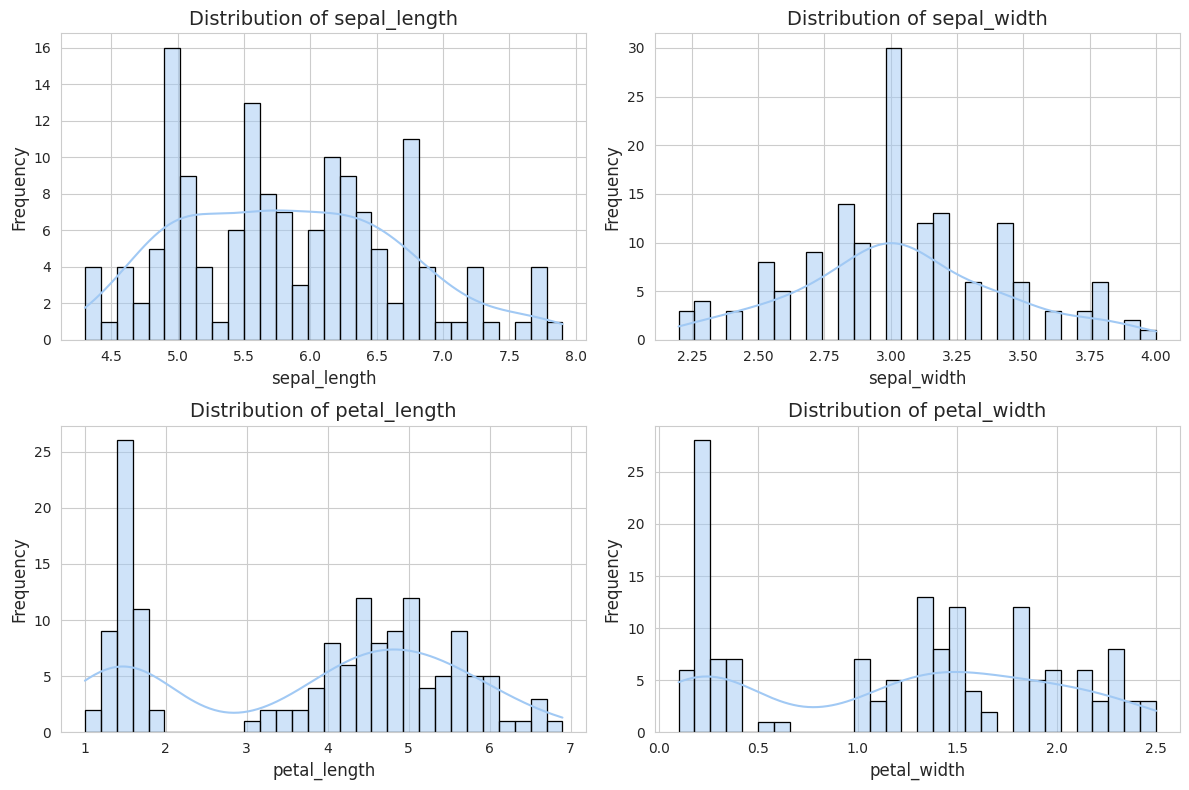

In [11]:
# Set Seaborn style
sns.set_style("whitegrid")
sns.set_palette("pastel")

num_cols = df.select_dtypes(include=['number']).columns  # Auto-select numerical columns

# Define the number of rows and columns for subplots
num_plots = len(num_cols)
cols = 2  # Number of columns in the grid
rows = (num_plots // cols) + (num_plots % cols > 0)  # Calculate rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of single row

# Plot histograms
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, edgecolor="black")
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


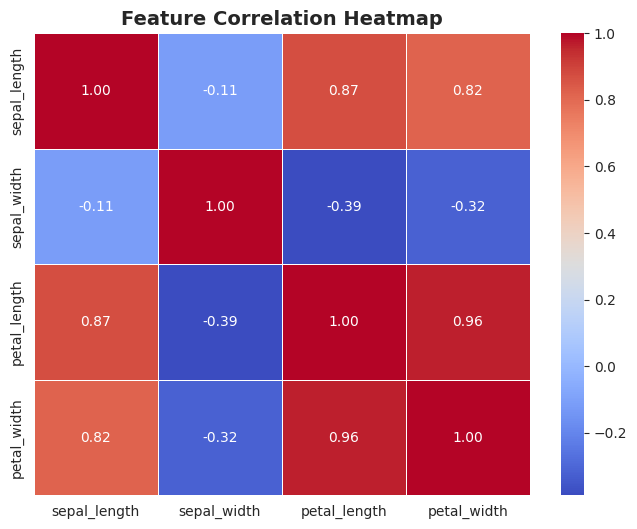

In [12]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Set figure size and style
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")

# Show the plot
plt.show()

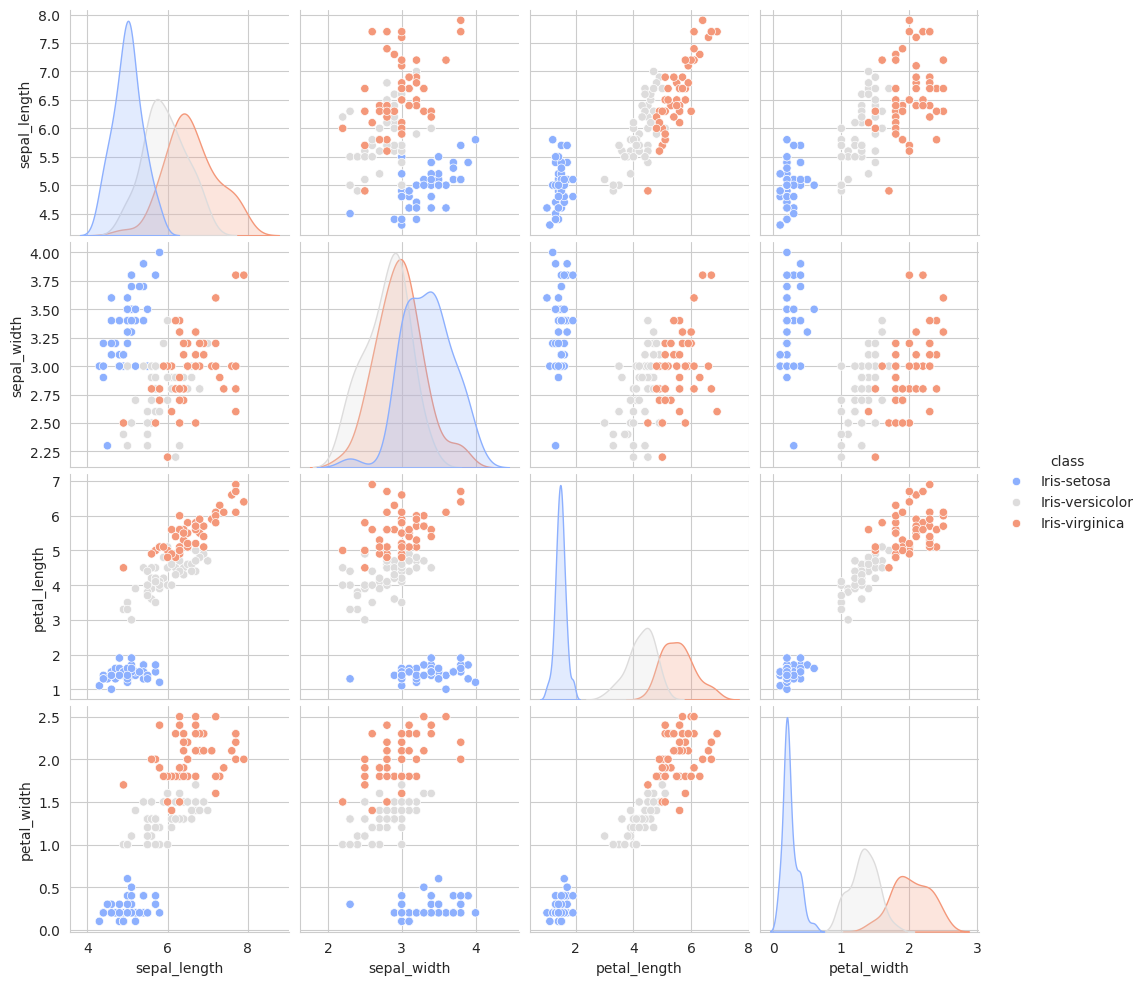

In [13]:
# Create a pairplot with class-based coloring
sns.pairplot(df, hue="class", palette="coolwarm", diag_kind="kde")

# Show the plot
plt.show()

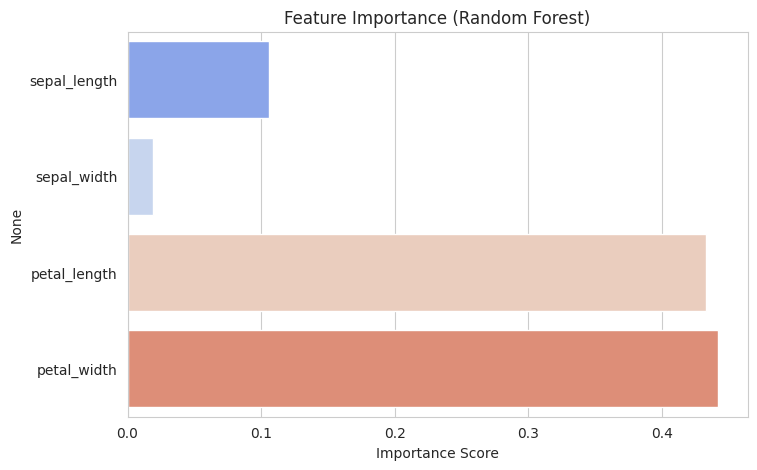

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(df[num_cols], df["class"])
importances = rf.feature_importances_

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=num_cols, palette="coolwarm")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

In [15]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the 'class' column
df['class'] = le.fit_transform(df['class'])

# Display the first few rows to show the encoded 'class' column
print(df.head())

   sepal_length  sepal_width  petal_length  petal_width  class
1           5.1          3.5           1.4          0.2      0
2           4.9          3.0           1.4          0.2      0
3           4.7          3.2           1.3          0.2      0
4           4.6          3.1           1.5          0.2      0
5           5.0          3.6           1.4          0.2      0


In [16]:
X = df.drop("class", axis=1)
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Feed-Forward Neural Network (FFNN) with early stopping
def Feed_Forward_NN_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


ffnnm = Feed_Forward_NN_model()
ffnnm.fit(X_train_scaled, y_train, epochs=50, batch_size=8, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluate FFNN
ffnn_pred = ffnnm.predict(X_test_scaled).argmax(axis=1)
ffnn_acc = accuracy_score(y_test, ffnn_pred)


print(f"FFNN Accuracy: {ffnn_acc:.4f}")


"""
There is a problem with the results review with dr. Montazerian

The model should not be 100% accurate

"""

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3329 - loss: 1.1687 - val_accuracy: 0.5333 - val_loss: 0.9722
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5800 - loss: 0.9247 - val_accuracy: 0.9000 - val_loss: 0.7786
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8479 - loss: 0.7594 - val_accuracy: 0.9000 - val_loss: 0.6201
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7720 - loss: 0.6406 - val_accuracy: 0.9000 - val_loss: 0.4958
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8035 - loss: 0.5497 - val_accuracy: 0.9000 - val_loss: 0.4000
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8183 - loss: 0.4488 - val_accuracy: 0.9333 - val_loss: 0.3306
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8606 - loss: 0.3718 - val_accuracy: 0.9333 - val_loss: 0.2842
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8298 - loss: 0.3404 - val_accuracy: 0.9333 - val_loss

'\nThere is a problem with the results review with dr. Montazerian\n\n\n\n\n\n'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



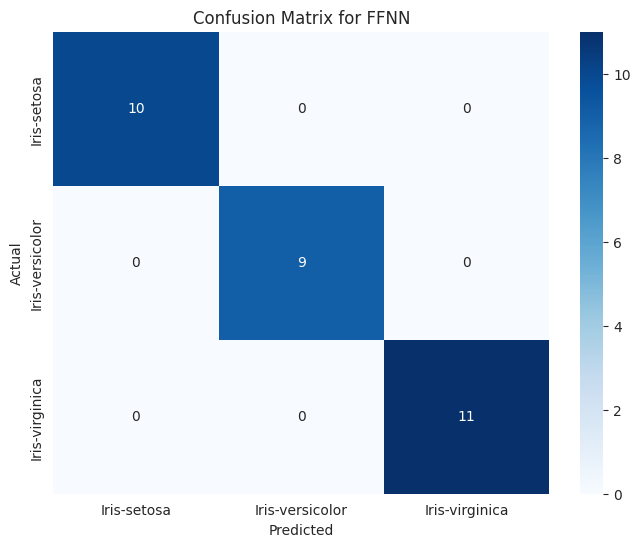

In [19]:
# Classification report (Precision, Recall, F1-score)
print(classification_report(y_test, ffnn_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, ffnn_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for FFNN")
plt.show()


In [20]:
# Define the Convolutional Neural Network (CNN)
def build_cnn():
    model = keras.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
        layers.Conv1D(32, kernel_size=2, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = build_cnn()
cnn.fit(X_train_scaled, y_train, epochs=75, batch_size=8, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluate CNN
cnn_pred = cnn.predict(X_test_scaled).argmax(axis=1)
cnn_acc = accuracy_score(y_test, cnn_pred)

print(f"CNN Accuracy: {cnn_acc:.4f}")

Epoch 1/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2441 - loss: 1.1136 - val_accuracy: 0.4000 - val_loss: 1.0762
Epoch 2/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4024 - loss: 1.0718 - val_accuracy: 0.5667 - val_loss: 1.0385
Epoch 3/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5309 - loss: 1.0328 - val_accuracy: 0.5667 - val_loss: 1.0039
Epoch 4/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5967 - loss: 0.9824 - val_accuracy: 0.6000 - val_loss: 0.9658
Epoch 5/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5318 - loss: 0.9851 - val_accuracy: 0.6000 - val_loss: 0.9332
Epoch 6/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6337 - loss: 0.9156 - val_accuracy: 0.6000 - val_loss: 0.9125
Epoch 7/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6297 - loss: 0.8909 - val_accuracy: 0.6333 - val_loss: 0.8846
Epoch 8/75
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6614 - loss: 0.8592 - val_accuracy: 0.7000 - val_loss

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.89      0.89      0.89         9
           2       1.00      0.73      0.84        11

    accuracy                           0.87        30
   macro avg       0.89      0.87      0.87        30
weighted avg       0.89      0.87      0.87        30



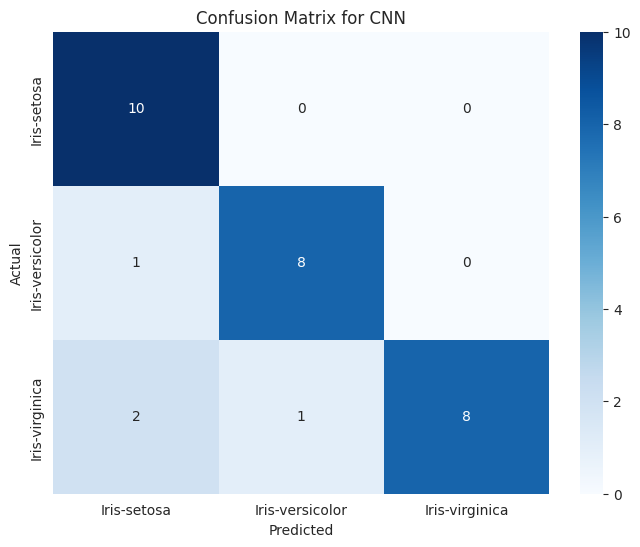

In [22]:

# Classification report (Precision, Recall, F1-score) for CNN
print(classification_report(y_test, cnn_pred))

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, cnn_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for CNN")
plt.show()


In [ ]:
"""
Add more evaluation diagrams for more illustration after review with dr. Montazerian
"""